# Film Junky Union: Sentiment Analysis for Movie Reviews

# Contents <a id='contents'></a>

[1. Contents](#contents)   
[2. Introduction](#introduction)  
[3. Project Goal](#project_goal)     
[4. Initialization](#initialization)  
[5. Load data & Data description ](#load-data)   
[6. EDA](#eda)   
[7. Evaluation Procedure](#evaluation-procedure)    
[8. Normalization](#normalization)  
[9. Train / Test Split](#train-test-split)  
[10. Working with models](#working-with-models)  
[11. My Reviews](#my-reviews)  
[12. Conclusion](#conclusion)  

# 1. Introduction <a id='introduction'></a> 
[Back to Contents](#contents)

In the age of digital content and streaming services, movie reviews play a pivotal role in helping viewers make informed choices about what to watch. **The "Film Junky Union" project, an exciting venture for classic movie enthusiasts, seeks to revolutionize this experience by developing an innovative system for filtering and categorizing movie reviews**. By leveraging the power of machine learning, our primary objective is to create a model capable of automatically detecting negative movie reviews, aiding film aficionados in avoiding cinematic disappointments.To achieve this, we will utilize a comprehensive dataset of IMDb movie reviews, with polarity labels indicating whether a review is positive or negative. Through data preprocessing, exploratory data analysis (EDA), model training, and rigorous testing, **we aim to construct a robust classifier capable of achieving an F1 score of at least 0.85**. The project's findings will not only provide valuable insights into sentiment analysis within the film industry but also empower movie enthusiasts to make more informed viewing decisions.

# 2. Project Goal <a id='project_goal'></a>  
[Back to Contents](#contents)

Few of our main goals are:
1. **Data Preprocessing**: Clean and preprocess the IMDb movie review dataset, including handling missing values, text cleaning, and tokenization.

2. **Exploratory Data Analysis (EDA)**: Perform EDA to gain insights into the data distribution, class balance, and other characteristics of the dataset.

3. **Sentiment Analysis Model**: Develop a sentiment analysis model that can classify movie reviews as positive or negative based on their text content.

4. **F1 Score of 0.85**: Achieve a minimum F1 score of 0.85 to ensure the model's accuracy in detecting negative reviews.

# 3. Initialization <a id='initialization'></a>  
[Back to Contents](#contents)

In [1]:
# Import libraries for data preprocessing & manipulation
import numpy as np
import pandas as pd

# Import libraries / modules for visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Import libraries for natural language processing
import nltk
import spacy

# Import libraries for texts preprocessing
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler

# Import PyTorch and Transformers libraries to easily download & train pretrained models
import torch
import transformers

# Import ML models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

#Import accuracy metrics
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# Import other helper libraries 
import math
import re
from tqdm.auto import tqdm

# Import library to ignore warning
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

# 4. Load data & Data description <a id='load-data'></a>  
[Back to Contents](#contents)

The data is stored in the `/datasets/imdb_reviews.tsv` file.  

_The data was provided by Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011)._  

Here's the **description of the selected fields**:
- `review`: the review text
- `pos`: the target, '0' for negative and '1' for positive
- `ds_part`: 'train'/'test' for the train/test part of dataset, correspondingly

In [4]:
# Load the data from the file
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
# Get a peek into the data
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


Great! So, we have successfully loaded the data and had a peek into it. Let's check the general info about the DataFrame - `df_reviews`:

In [6]:
# Get general info about the DataFrame
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

This DataFrame - `df_reviews` contains movie-related data with 47,331 entries and 17 columns. It includes information about movie titles, release years, genres, ratings, and reviews. The 'pos' column indicates the sentiment polarity, where '1' represents positive reviews. The dataset is divided into 'train' and 'test' parts for the purpose of training and evaluating sentiment analysis models.

<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was loaded and inspected

</div>

We're doing great 😎. Let's see what the descriptive statistics look like:

In [7]:
# Get the descriptive statistics
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


The `pos` column appears to be well-balanced, with an almost equal number of positive and negative reviews. This balance is indicated by the mean value of approximately 0.499. However, there is notable variability in sentiment, as indicated by the relatively high standard deviation.

# 5. EDA <a id='eda'></a>  
[Back to Contents](#contents)

Let's check the number of movies and reviews over years.

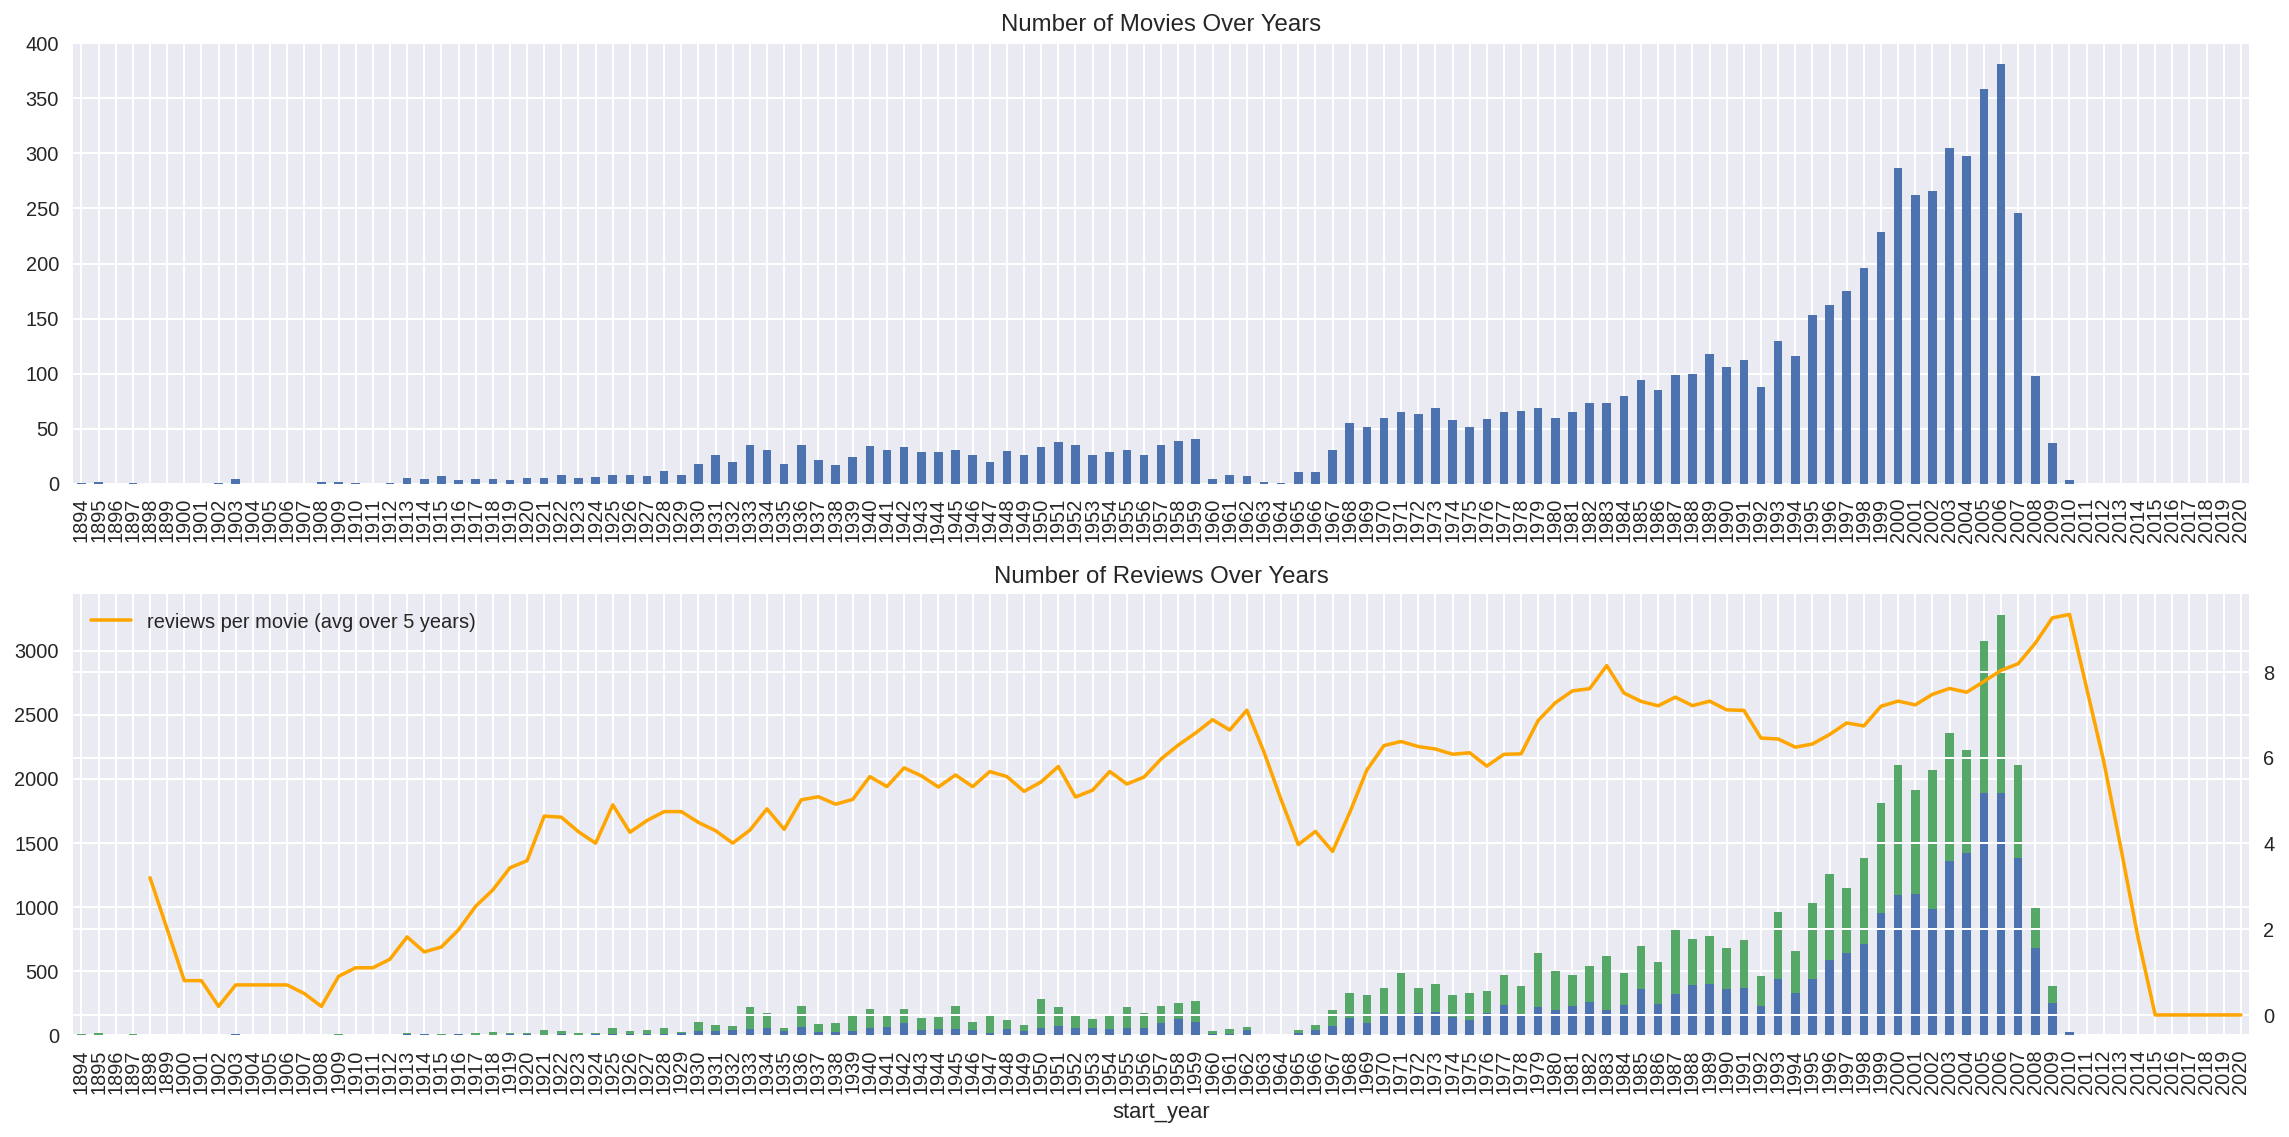

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

**There is a noticeable upward trend in the number of movies produced up until the year 2007**. As a result, the dataset reflects a range of 250 to 3,250 reviews per movie during this period. This suggests that the movie industry experienced significant growth, particularly in the years leading up to 2007, leading to a larger number of movies and a wide range of review counts for each film.

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

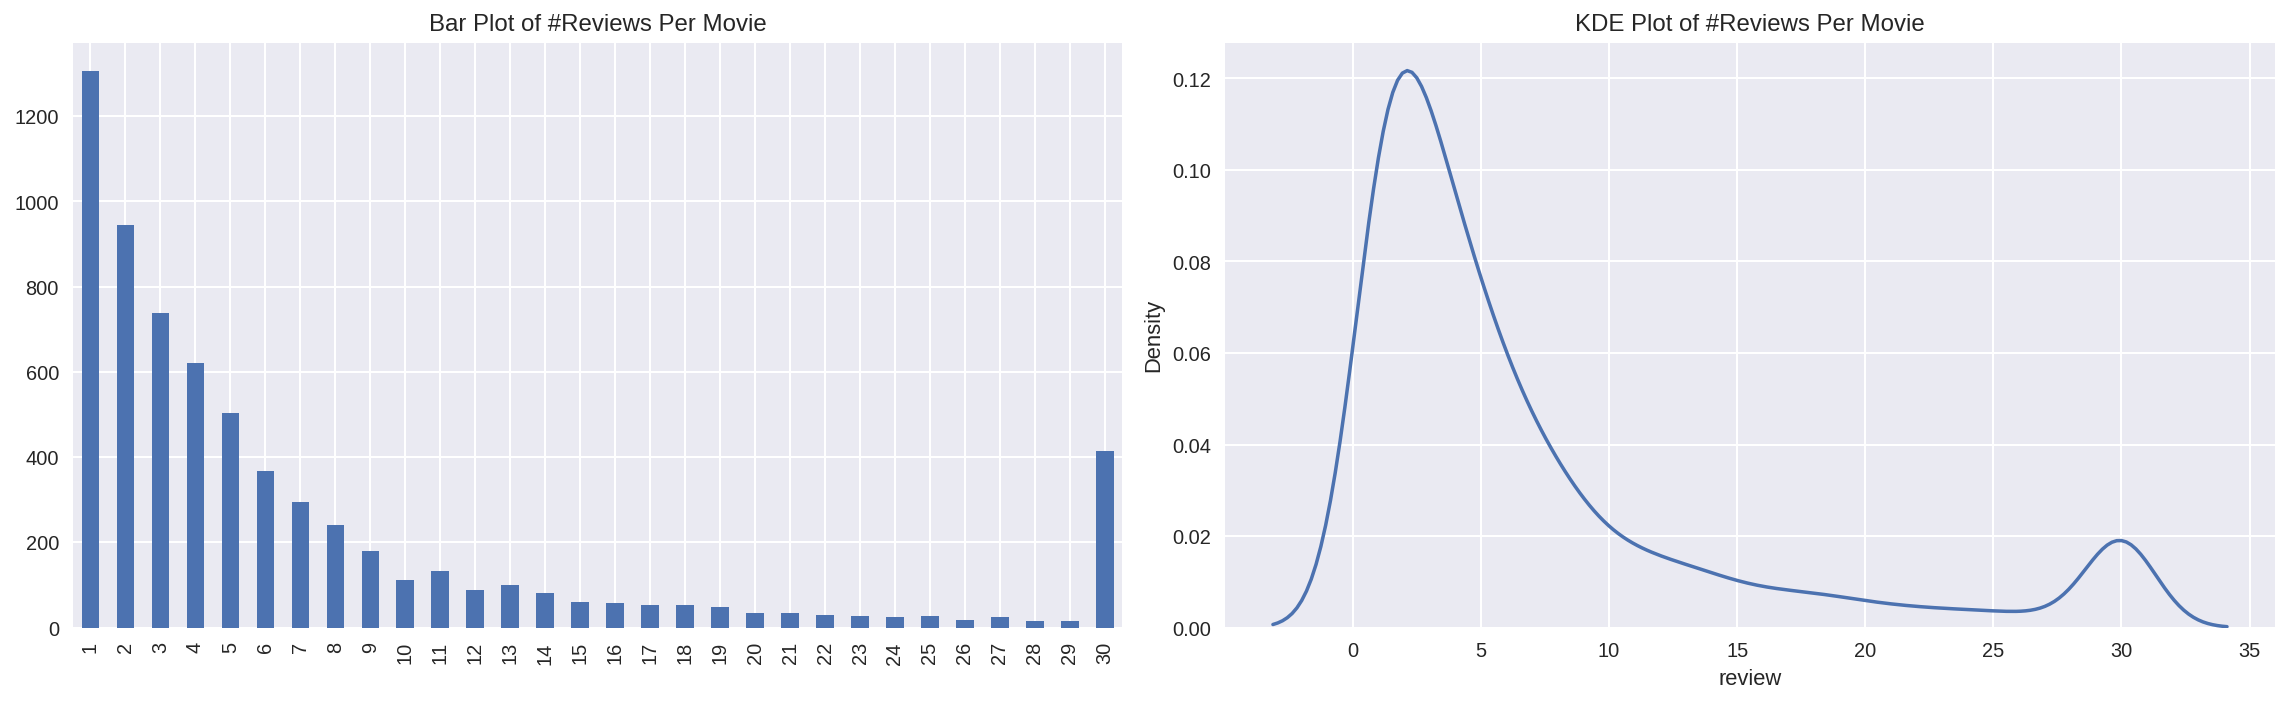

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

The 'pos' column serves as a binary classifier for each review. A label of 0 designates a negative review, while a label of 1 signifies a positive review. Let's see how the values are distributed:

In [10]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

Great! **It seems the values are almost equally distributed between the two classes**. There are 23616 positive reviews and 23715 negative reviews.

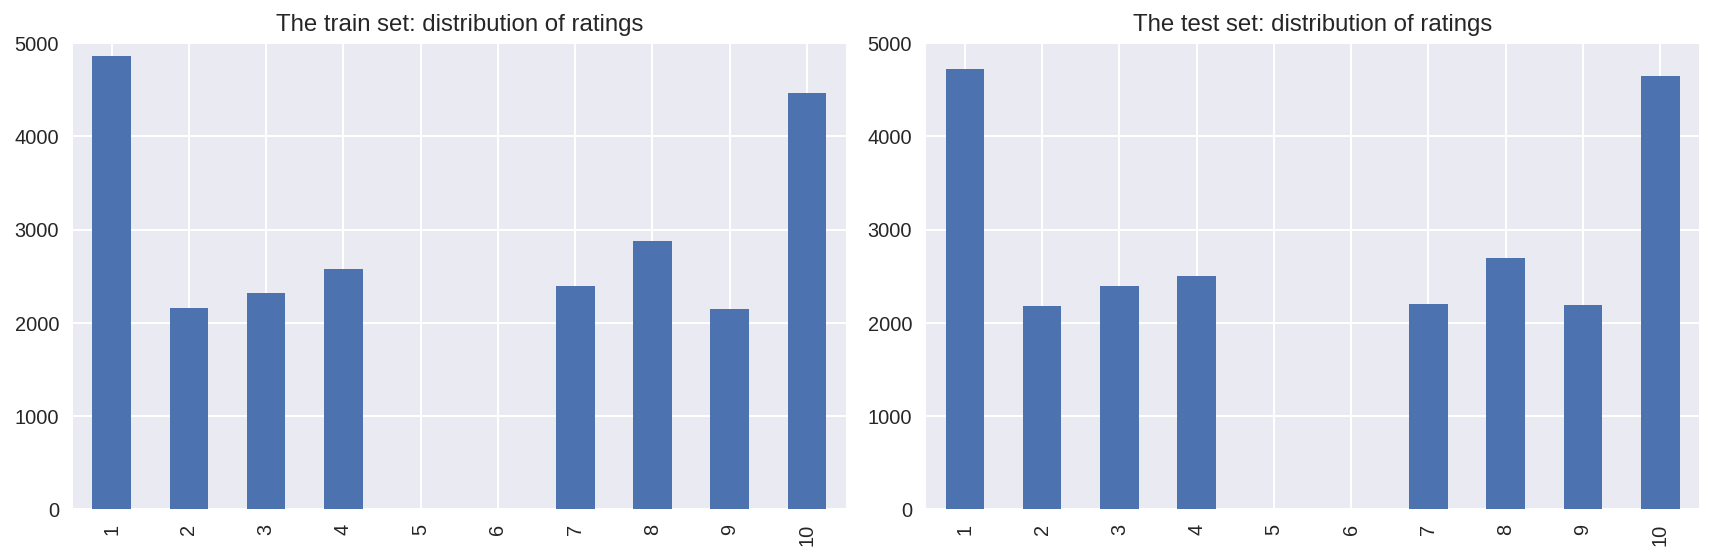

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

The distribution of movie ratings in both the train and test datasets exhibits a similar pattern. To visualize this further, we can plot how negative and positive reviews are distributed across different years.

Distribution of negative and positive reviews over the years for two parts of the dataset:

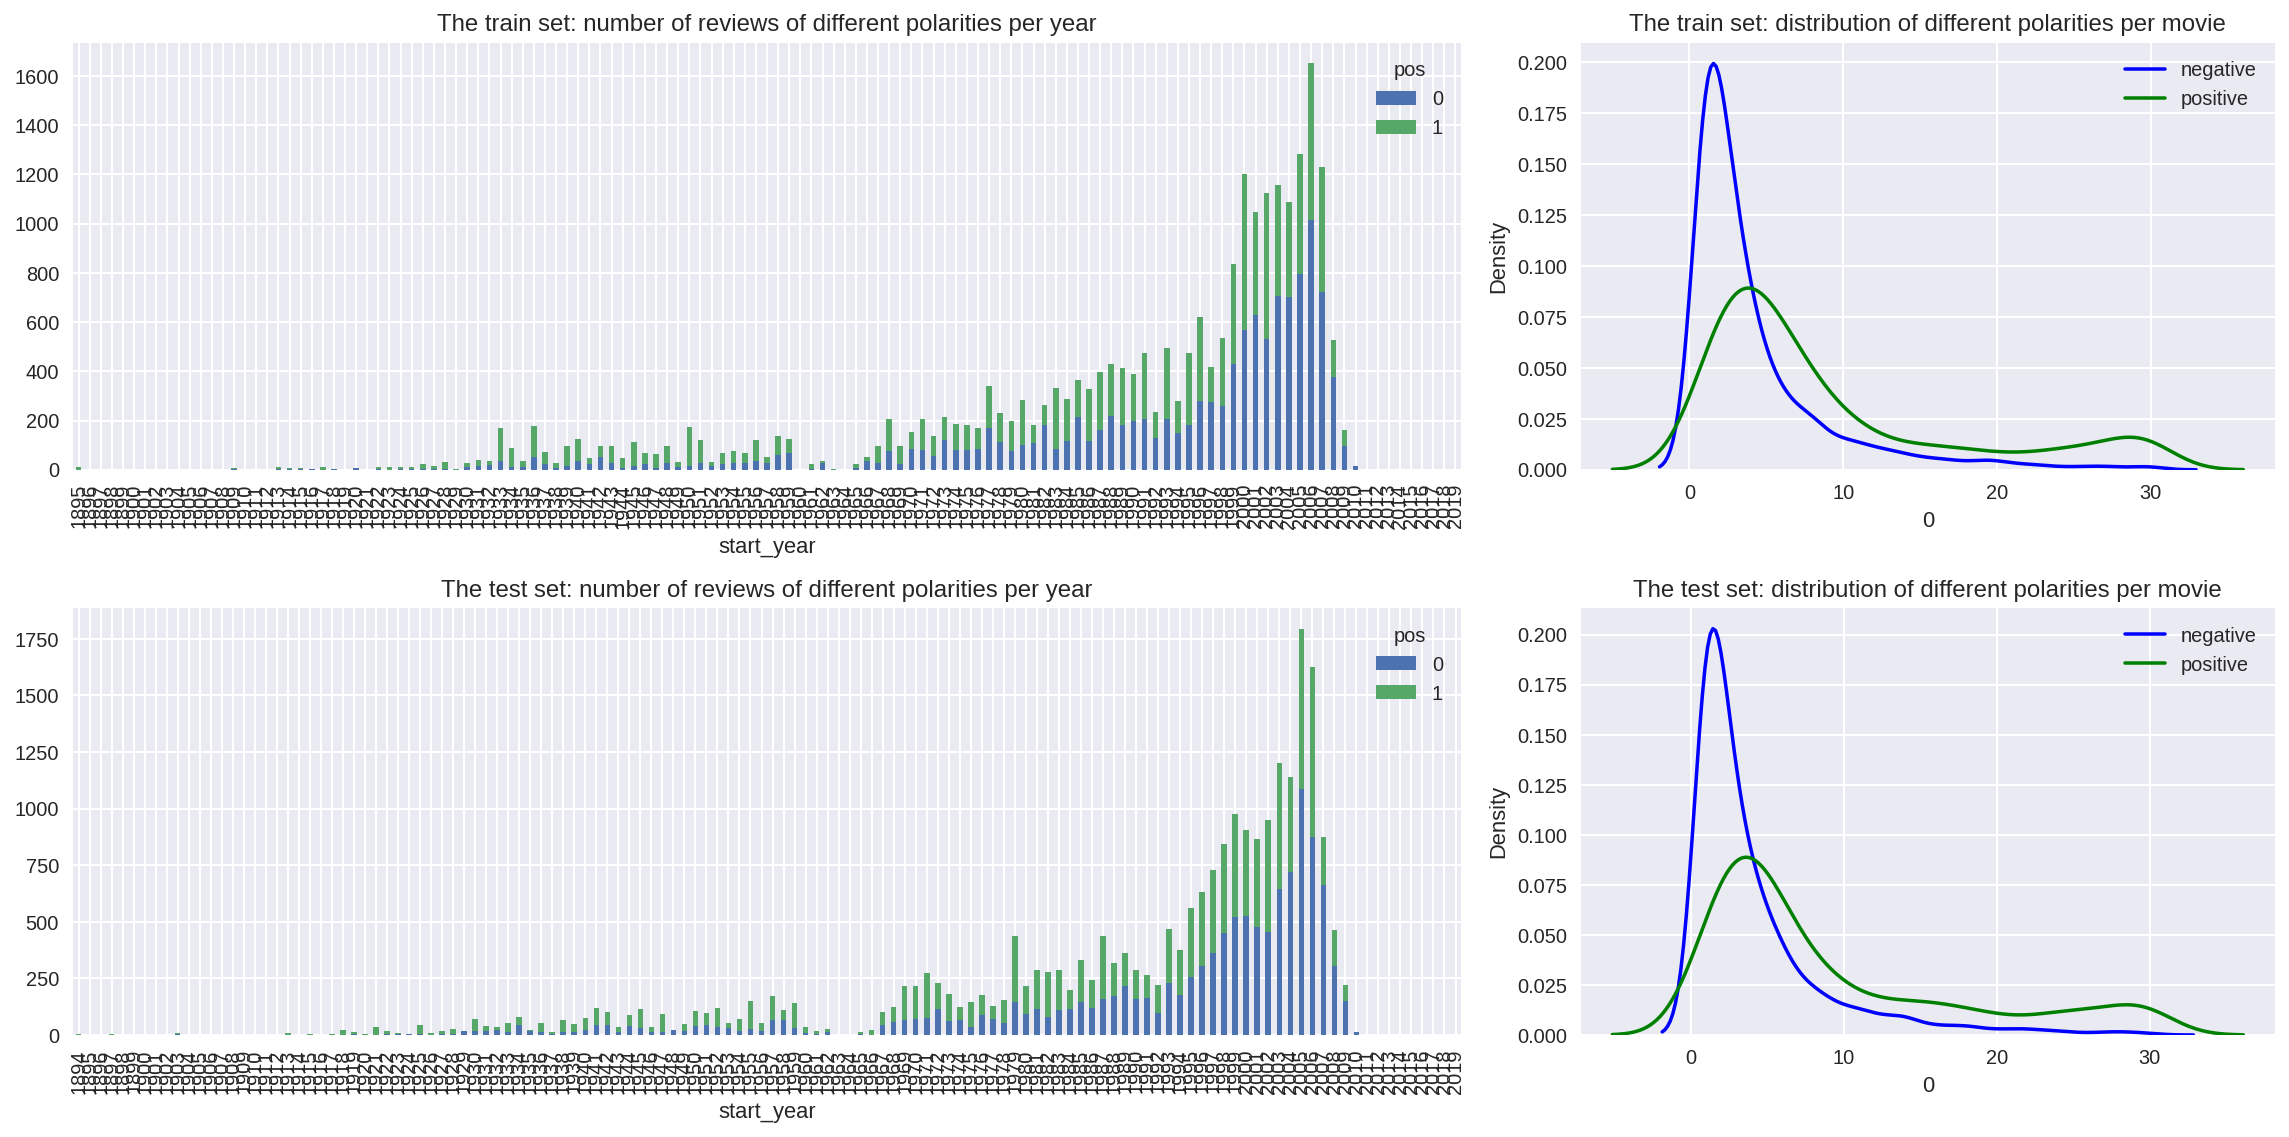

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

The negative and positive reviews are distributed across different years almost similarly.

# 6. Evaluation Procedure  <a id='evaluation-procedure'></a>  
[Back to Contents](#contents)

Composing an evaluation routine which can be used for all models in this project

In [13]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

# 7. Normalization <a id='normalization'></a>  
[Back to Contents](#contents)

We assume that all the models below accept text inputs in lowercase and devoid of any digits, punctuation marks, or special characters.

In [14]:
# Function to preprocess the data
def normalize_data(data):
    ''' 
        Cleans the data of any digits, punctuation marks, or special characters (except apostrophes)
    '''
    clean_data = re.sub(r"[^a-zA-Z']", " ", data)
    clean_data = " ".join(clean_data.split())
    return clean_data.lower()

In [15]:
df_reviews['review_norm'] = df_reviews['review'].apply(normalize_data)
df_reviews['review_norm'].head(10)

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
2    there is no real story the film seems more lik...
3    um a serious film about troubled teens in sing...
4    i'm totally agree with garryjohal from singapo...
5    this is the first movie i've seen from singapo...
6    yes non singaporean's can't see what's the big...
7    this true story of carlson's raiders is more o...
8    should have been titled 'balderdash ' little i...
9    the movie 'gung ho ' the story of carlson's ma...
Name: review_norm, dtype: object

Now, we've a clean dataset which we can use to train our models.

# 8. Train / Test Split <a id='train-test-split'></a>  
[Back to Contents](#contents)

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is `ds_part`.

In [16]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

# Get the targets
train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

# Get the features
train_features = df_reviews_train['review_norm']
test_features = df_reviews_test['review_norm']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


# 9. Working with models <a id='working-with-models'></a>  
[Back to Contents](#contents)

## Model 0 - Constant

Let's first train and test a constant model:

In [17]:
%%time

# Instantiate the model
dummy_const_model = DummyClassifier()

# Train the model on the training set
dummy_const_model.fit(train_features, train_target)

# OUTPUT
# CPU times: user 2.32 ms, sys: 212 µs, total: 2.53 ms
# Wall time: 1.63 ms

CPU times: user 2.23 ms, sys: 189 µs, total: 2.42 ms
Wall time: 1.52 ms


DummyClassifier()

Let's evaluate the model:

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


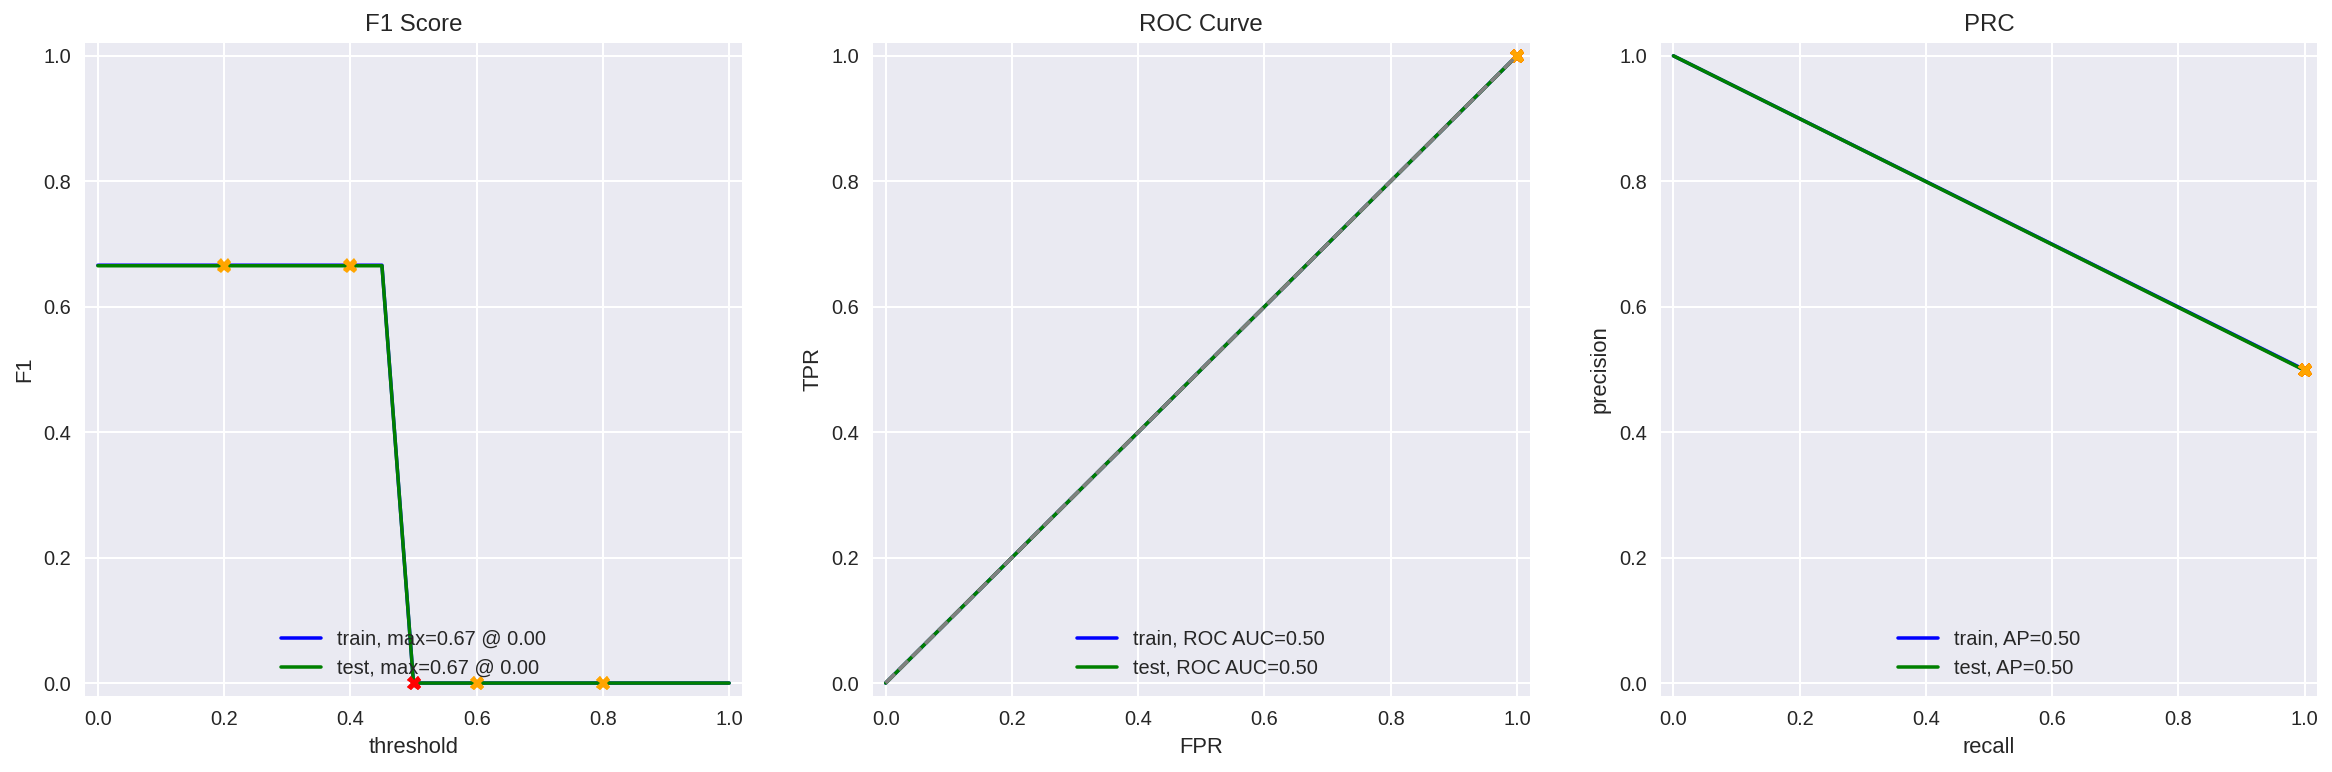

In [18]:
# Evaluate the model using the function - evaluate_model
evaluate_model(dummy_const_model, train_features, train_target, test_features, test_target)

Okay. We've got an accuracy of 50% and an F1 score of 0.5 for the above baseline model.

## Model 1 - NLTK, TF-IDF and LR

We'll try the **Logistic Regression** model with **NLTK** preprocessing and **TF-IDF** vectorization:

In [19]:
# Pre-process the text
stop_words = set(stopwords.words('english'))
text_transformer_tf_idf = TfidfVectorizer(stop_words='english')

In [20]:
# Function to tokenize and lemmatize text using NLTK
def tokenize_n_lemmatize_using_nltk(text):
    lemmatizer  = WordNetLemmatizer()
    tokens = word_tokenize(text.lower())
    lemmas = [lemmatizer.lemmatize(token) for token in tokens] 
    lemmatized_text = " ".join(lemmas) 
    return lemmatized_text

In [21]:
# Apply tokenization and lemmatization to features
df_reviews_train['review_lemm_nltk'] = train_features.apply(tokenize_n_lemmatize_using_nltk)
df_reviews_test['review_lemm_nltk'] = test_features.apply(tokenize_n_lemmatize_using_nltk)

In [22]:
# Calculate the features for training and test set
train_features_nltk = text_transformer_tf_idf.fit_transform(df_reviews_train['review_lemm_nltk'])
test_features_nltk = text_transformer_tf_idf.transform(df_reviews_test['review_lemm_nltk'])

In [23]:
%%time
## Train logistic regression model

# Instantiate the model
logistic_reg_model = LogisticRegression(solver='liblinear', random_state=7654321)

# Train the model on the training set
logistic_reg_model.fit(train_features_nltk, train_target)

# OUTPUT
# CPU times: user 626 ms, sys: 1.56 s, total: 2.18 s
# Wall time: 2.13 s
# LogisticRegression(random_state=7654321, solver='liblinear')

CPU times: user 577 ms, sys: 1.52 s, total: 2.09 s
Wall time: 2.03 s


LogisticRegression(random_state=7654321, solver='liblinear')

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


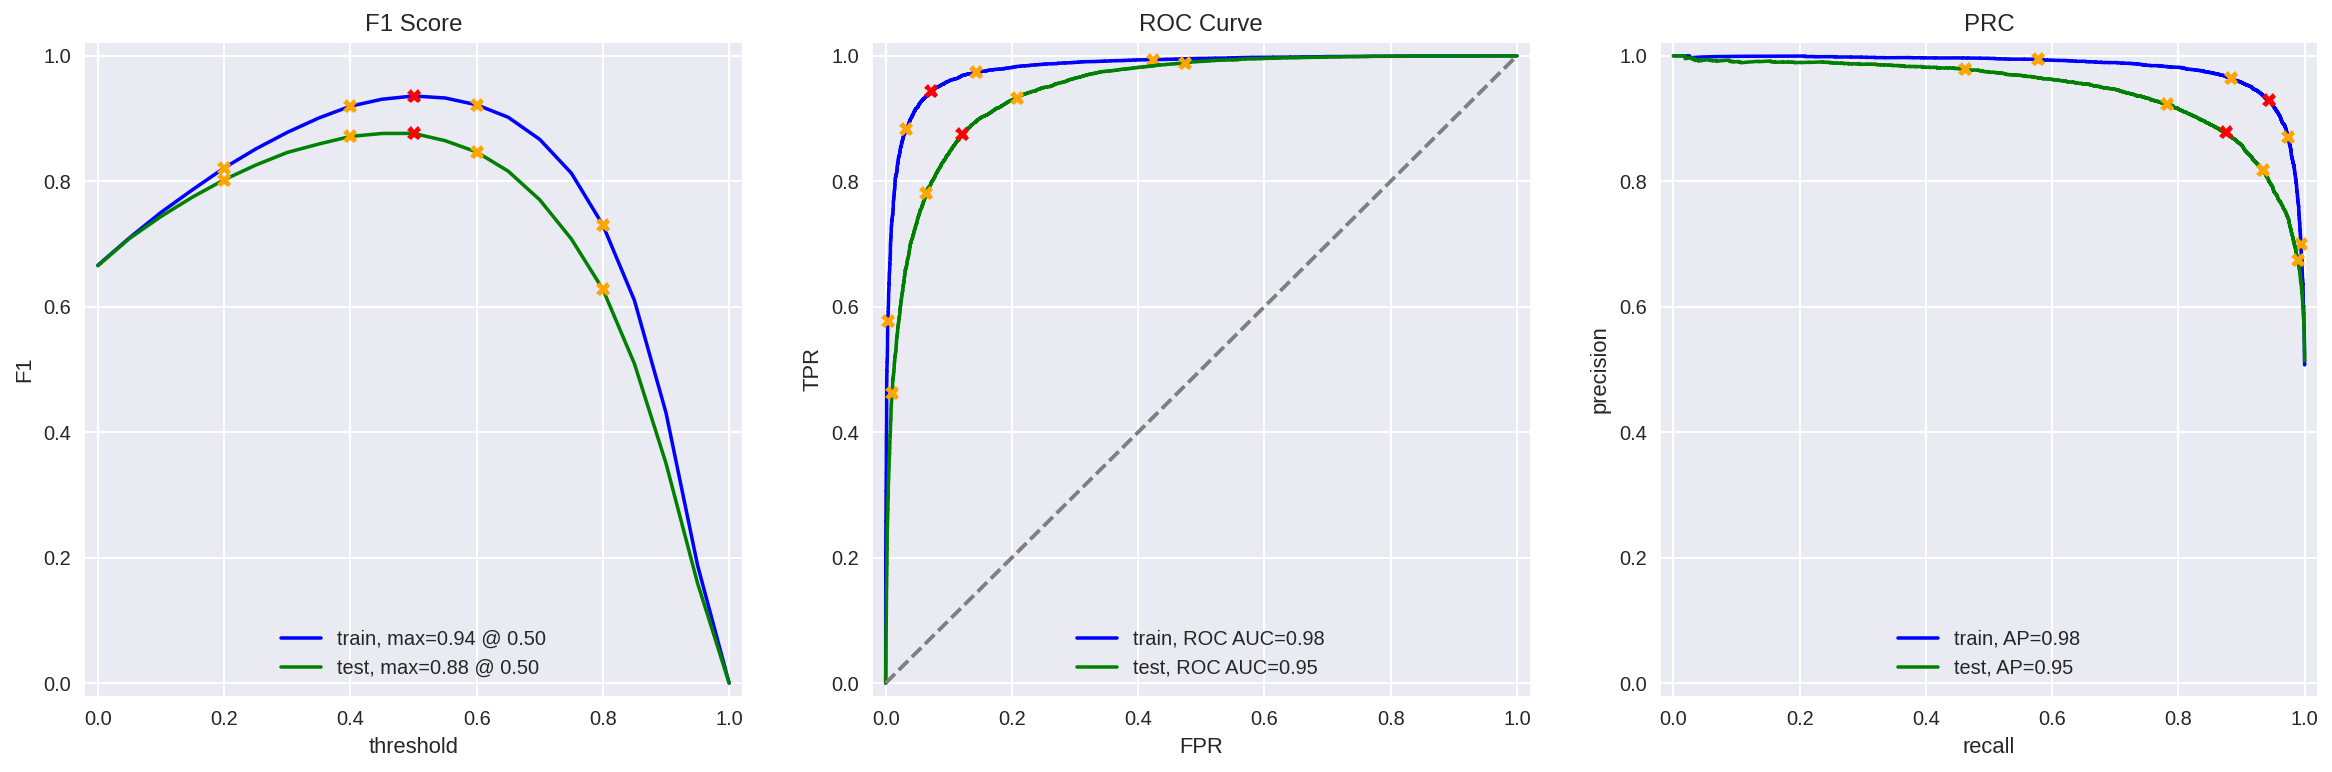

In [24]:
# Evaluate the model using the function - evaluate_model
evaluate_model(logistic_reg_model, train_features_nltk, train_target, test_features_nltk, test_target)

- **Accuracy**: The model exhibits high accuracy on both the training and test datasets, with 94% accuracy on the training data and 88% accuracy on the test data. This indicates that the model is performing well in classifying reviews as positive or negative.

- **F1 Score**: The F1 score, a measure that balances precision and recall, is also impressive, with a score of 0.94 on the training data and 0.88 on the test data. This suggests that the model is effective at correctly classifying both positive and negative reviews.

- **Average Precision Score (APS)**: The Average Precision Score is high, with a score of 0.98 on the training data and 0.95 on the test data. This indicates that the model's predictions for positive and negative reviews are of high quality, especially on the test data.

- **ROC AUC**: The ROC AUC score is high, with a value of 0.98 on the training data and 0.95 on the test data. This suggests that the model is effective at distinguishing between positive and negative reviews, with a high degree of separation between the two classes.

**The logistic regression classifier, which utilized NLTK preprocessing techniques, successfully reached above the targeted metric with an F1 score of 0.88**. Despite showing signs of potential overfitting, this classifier met the project's F1 score requirement.

## Model 2 - spaCy, TF-IDF and LR

We'll try the **Logistic Regression** model with **spaCy** preprocessing and **TF-IDF** vectorization:

In [25]:
# Get list of lemmatized words
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [26]:
# Function to tokenize and lemmatize text using spaCy
def tokenize_n_lemmatize_using_spacy(text):
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    return ' '.join(tokens)

In [27]:
# Apply tokenization and lemmatization to features
df_reviews_train['review_lemm_spacy'] = train_features.apply(tokenize_n_lemmatize_using_spacy)
df_reviews_test['review_lemm_spacy'] = test_features.apply(tokenize_n_lemmatize_using_spacy)

In [28]:
# Calculate the features for training and test set
train_features_spacy = text_transformer_tf_idf.fit_transform(df_reviews_train['review_lemm_spacy'])
test_features_spacy = text_transformer_tf_idf.transform(df_reviews_test['review_lemm_spacy'])

In [29]:
%%time
## Train logistic regression model

# Instantiate the model
logistic_reg_model_2 = LogisticRegression(solver='liblinear', random_state=7654321)

# Train the model on the training set
logistic_reg_model_2.fit(train_features_spacy, train_target)

# OUTPUT
# CPU times: user 709 ms, sys: 1.85 s, total: 2.56 s
# Wall time: 2.52 s
# LogisticRegression(random_state=7654321, solver='liblinear')

CPU times: user 709 ms, sys: 1.85 s, total: 2.56 s
Wall time: 2.52 s


LogisticRegression(random_state=7654321, solver='liblinear')

          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95


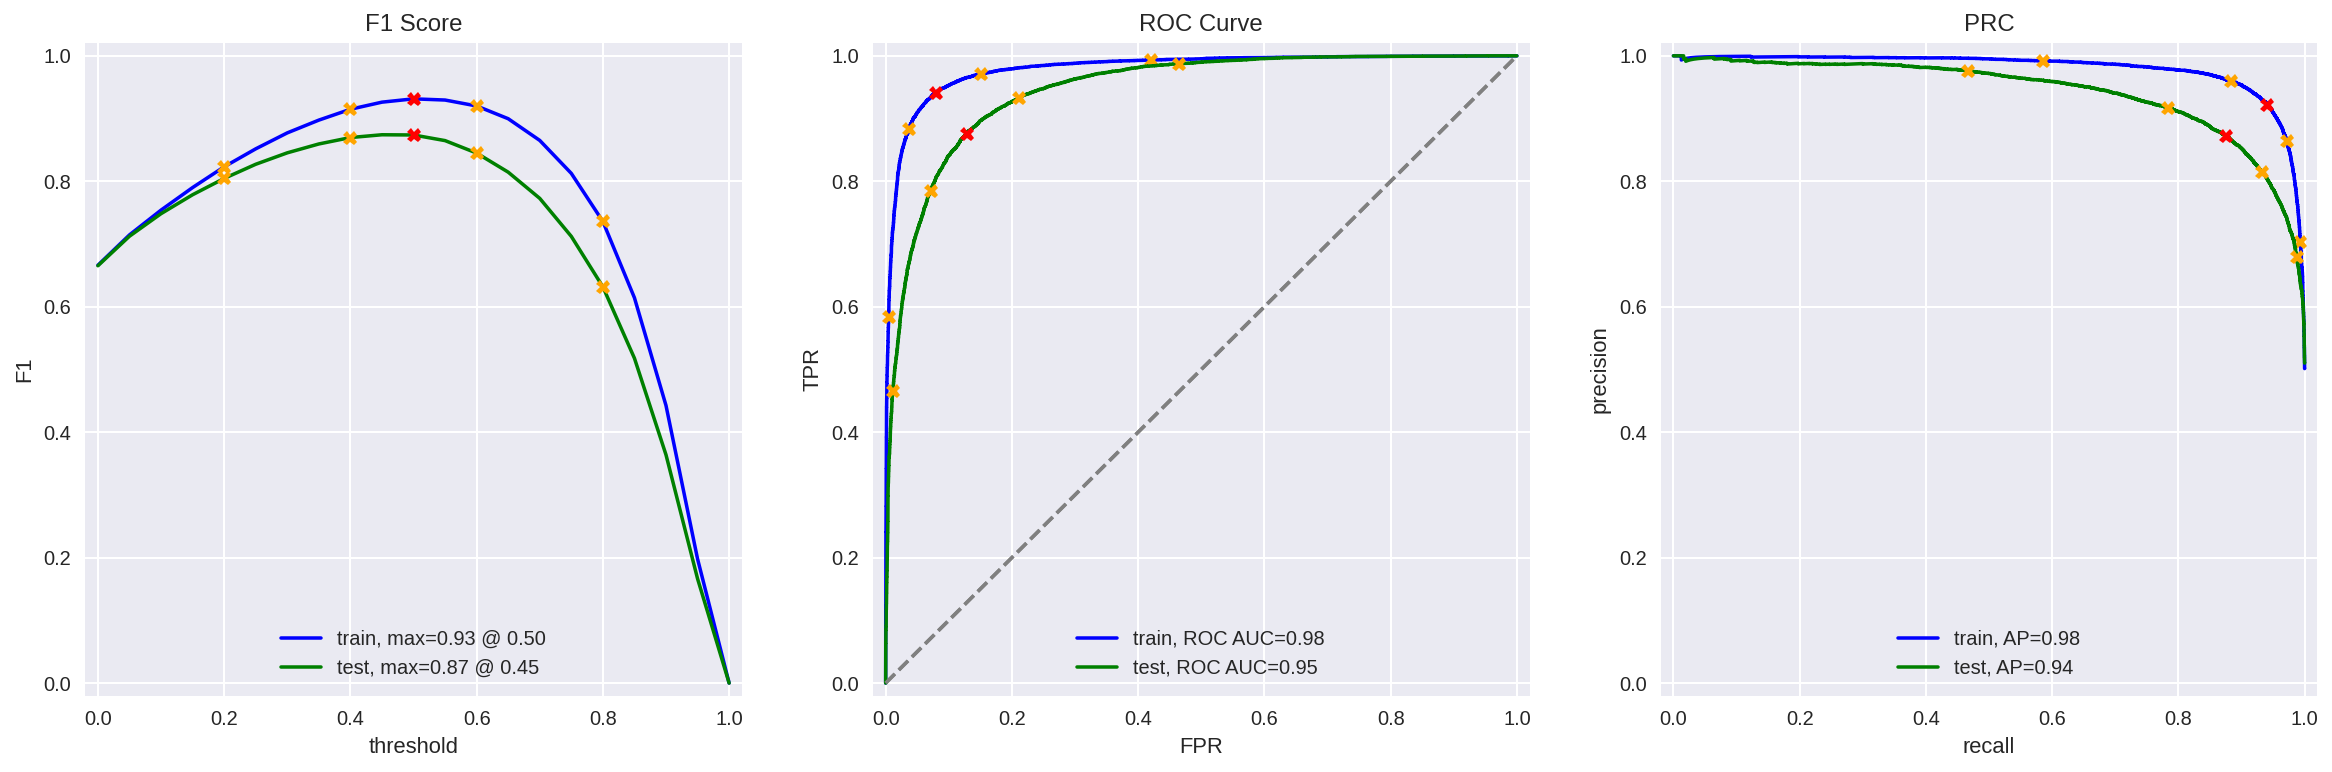

In [30]:
# Evaluate the model using the function - evaluate_model
evaluate_model(logistic_reg_model_2, train_features_spacy, train_target, test_features_spacy, test_target)

- **Accuracy**: The model demonstrates strong accuracy on both the training and test datasets, with 93% accuracy on the training data and 87% accuracy on the test data. This suggests that the model performs well in classifying reviews as positive or negative.

- **F1 Score**: The F1 score, a balanced measure of precision and recall, is also commendable, with a score of 0.93 on the training data and 0.87 on the test data. This indicates the model's ability to accurately classify both positive and negative reviews.

- **Average Precision Score (APS)**: The Average Precision Score is high, with a score of 0.98 on the training data and 0.94 on the test data. This signifies the model's effectiveness in providing high-quality predictions for positive and negative reviews, especially on the test dataset.

- **ROC AUC**: The ROC AUC score is high, with a value of 0.98 on the training data and 0.95 on the test data. This indicates that the model excels in distinguishing between positive and negative reviews, with a high degree of class separation.

In summary, the **Logistic Regression** model, when applied with **spaCy** preprocessing and **TF-IDF** vectorization, maintains a strong performance in classifying movie reviews. It exhibits high accuracy, F1 score, Average Precision Score, and ROC AUC on both the training and test datasets, underscoring its proficiency in sentiment analysis

## Model 3 - spaCy, TF-IDF and LGBMClassifier

We'll try the **LGBMClassifier** model with **NLTK** preprocessing and **TF-IDF** vectorization:

In [31]:
%%time
## Train LGBMClassifier model

# Instantiate the model
lgbm_model = LGBMClassifier(random_state=7654321)

# Train the model on the training set
lgbm_model.fit(train_features_spacy, train_target)

# OUTPUT
# CPU times: user 1min 5s, sys: 273 ms, total: 1min 5s
# Wall time: 1min 5s
# LGBMClassifier(random_state=7654321)

CPU times: user 1min 5s, sys: 273 ms, total: 1min 5s
Wall time: 1min 5s


LGBMClassifier(random_state=7654321)

          train  test
Accuracy   0.91  0.85
F1         0.91  0.85
APS        0.97  0.93
ROC AUC    0.97  0.93


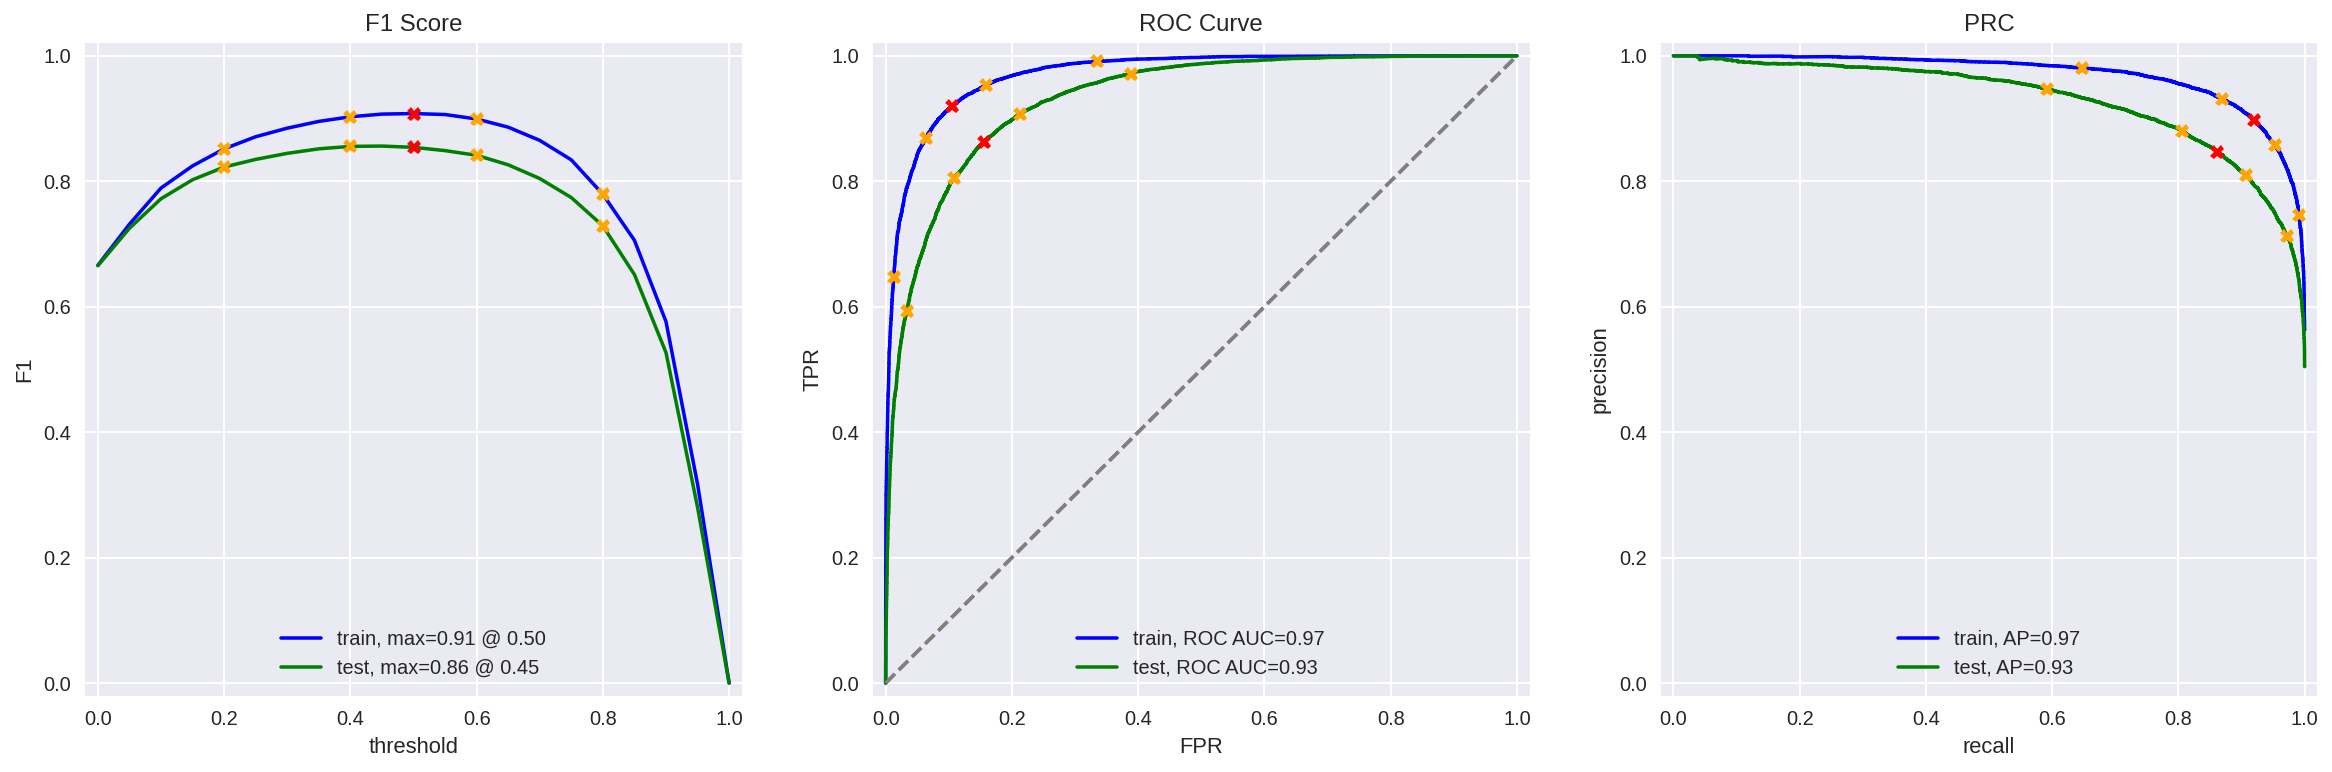

In [32]:
# Evaluate the model using the function - evaluate_model
evaluate_model(lgbm_model, train_features_spacy, train_target, test_features_spacy, test_target)

- **Accuracy**: The model demonstrates nice accuracy on both the training and test datasets, with 91% accuracy on the training data and 85% accuracy on the test data. This indicates that the model performs well in classifying reviews as positive or negative.

- **F1 Score**: The F1 score, which balances precision and recall, is also solid, with a score of 0.91 on the training data and 0.85 on the test data. This suggests that the model is effective at accurately classifying both positive and negative reviews.

- **Average Precision Score (APS)**: The Average Precision Score is high, with a score of 0.97 on the training data and 0.93 on the test data. This implies that the model provides high-quality predictions for positive and negative reviews, particularly on the test dataset.

- **ROC AUC**: The ROC AUC score is high, with a value of 0.97 on the training data and 0.93 on the test data. This indicates the model's proficiency in distinguishing between positive and negative reviews with a strong degree of class separation.

In conclusion, the **LGBMClassifier** model, coupled with **spaCy** preprocessing and **TF-IDF** vectorization, maintains a strong performance in classifying movie reviews. It achieves solid accuracy, F1 score, Average Precision Score, and ROC AUC on both the training and test datasets, demonstrating its effectiveness in sentiment analysis.

##  Model 4 - BERT

In [33]:
# Define maximum sample size
# max_sample_size = 500

In [34]:
# tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
# config = transformers.BertConfig.from_pretrained('bert-base-uncased')
# bert_model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [35]:
# def BERT_text_to_embeddings(texts, max_length=512, batch_size = 25, force_device=None, disable_progress_bar=False):
    
#     ids_list = []
#     attention_mask_list = []
#     max_sample_size = 500

#     # text to padded ids of tokens along with their attention masks
#     for input_text in texts.iloc[:max_sample_size]:
#         ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
#         padded = np.array(ids + [0]*(max_length - len(ids)))
#         attention_mask = np.where(padded != 0, 1, 0)
#         ids_list.append(padded)
#         attention_mask_list.append(attention_mask)
    
#     if force_device is not None:
#         device = torch.device(force_device)
#     else:
#         device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
#     print(f'device: {device}')
#     bert_model.to(device)
#     if not disable_progress_bar:
#         print(f'Using the {device} device.')
    
#     # Get embeddings in batches
#     embeddings = []

#     for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
#         ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
#         # create attention_mask_batch
#         attention_mask_batch = torch.LongTensor(
#             attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
            
#         with torch.no_grad():            
#             bert_model.eval()
#             batch_embeddings = bert_model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
#         embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
#     return np.concatenate(embeddings)

In [36]:
# %%time
# # Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
# train_features_bert = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

# # Get 500 records
# train_target_bert = df_reviews_train.iloc[:max_sample_size]['pos']

In [37]:
# # Check the sizes of the training set features and target
# print(df_reviews_train['review_norm'].shape)
# print(train_features_bert.shape)
# print(train_target_bert.shape)

In [38]:
# %%time
# # Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
# test_features_bert = BERT_text_to_embeddings(df_reviews_test['review_norm'], force_device='cuda')

# # Get 500 records
# test_target_bert = df_reviews_test.iloc[:max_sample_size]['pos']

In [39]:
# # Check the sizes of the test set features and target
# print(df_reviews_test['review_norm'].shape)
# print(test_features_bert.shape)
# print(test_target_bert.shape)

In [40]:
# # we have got the embeddings, so we'll save them to have them ready
# np.savez_compressed('features_bert.npz', train_features_bert=train_features_bert, test_features_bert=test_features_bert)

In [41]:
# # and load when needed
# with np.load('features_bert.npz') as data:
#     train_features_bert = data['train_features_bert']
#     test_features_bert = data['test_features_bert']

In [42]:
# %%time
# ## Train logistic regression model

# # Instantiate the model
# logistic_reg_model_3 = LogisticRegression(solver='liblinear', random_state=7654321)

# # Train the model on the training set
# logistic_reg_model_3.fit(train_features_bert, train_target_bert)

# # OUTPUT

In [43]:
# # Evaluate the model using the function - evaluate_model
# evaluate_model(logistic_reg_model_3, train_features_bert, train_target_bert, test_features_bert, test_target_bert)

# 10. My Reviews <a id='my-reviews'></a>  
[Back to Contents](#contents)

In [44]:
# List of my reviews

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

# Preprocess the data
my_reviews['review_norm'] = my_reviews['review'].apply(normalize_data)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


## Model 1 - NLTK, TF-IDF and Logistic Regression

In [47]:
texts = my_reviews['review_norm']

# Refit the vectorizer
text_transformer_tf_idf.fit_transform(df_reviews_train['review_lemm_nltk'])

my_reviews_pred_prob = logistic_reg_model.predict_proba(text_transformer_tf_idf.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.08:  i did not simply like it not my kind of movie
0.07:  well i was bored and felt asleep in the middle of the movie
0.59:  i was really fascinated with the movie
0.23:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.36:  i didn't expect the reboot to be so good writers really cared about the source material
0.41:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.10:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.91:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


**The Logistic Regression model's predicted probabilities align well with the sentiment expressed in the lemmatized reviews**, demonstrating the model's ability to assess the positivity or negativity of the given text. **The model provides higher probabilities for positive sentiments and lower probabilities for negative sentiments**, with appropriate distinctions for mixed sentiments.

## Model 2 - spaCy, TF-IDF and Logistic Regression

In [48]:
texts = my_reviews['review_norm']

# Refit the vectorizer
text_transformer_tf_idf.fit_transform(df_reviews_train['review_lemm_spacy'])

my_reviews_pred_prob = logistic_reg_model_2.predict_proba(text_transformer_tf_idf.transform(texts.apply(lambda x: tokenize_n_lemmatize_using_spacy(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.19:  i did not simply like it not my kind of movie
0.08:  well i was bored and felt asleep in the middle of the movie
0.50:  i was really fascinated with the movie
0.14:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.23:  i didn't expect the reboot to be so good writers really cared about the source material
0.48:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.91:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


**The Logistic Regression model's predicted probabilities align well with the sentiment expressed in the lemmatized reviews**, demonstrating the model's ability to assess the positivity or negativity of the given text. **The model provides higher probabilities for positive sentiments and lower probabilities for negative sentiments**, with appropriate distinctions for mixed sentiments.

## Model 3 - spaCy, TF-IDF and LGBMClassifier

In [49]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = lgbm_model.predict_proba(text_transformer_tf_idf.transform(texts.apply(lambda x: tokenize_n_lemmatize_using_spacy(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.57:  i did not simply like it not my kind of movie
0.25:  well i was bored and felt asleep in the middle of the movie
0.60:  i was really fascinated with the movie
0.42:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.67:  i didn't expect the reboot to be so good writers really cared about the source material
0.59:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.33:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.78:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


**The LGBMClassifier model's predicted probabilities show varying degrees of agreement with the sentiment expressed in the lemmatized reviews**. While it often aligns well with the reviews, there are instances where the model's prediction differs from the expressed sentiment.

# 11. Conclusions <a id='conclusions'></a>  
[Back to Contents](#contents)

This project embarked on the task of sentiment analysis within the realm of classic movie reviews, aiming to build and evaluate machine learning models for classifying sentiment. We initiated our journey by preparing the data, conducting exploratory data analysis (EDA), and assessing the balance in the `pos` column, which ultimately revealed a reasonably balanced distribution of positive and negative reviews.  

We ventured into the world of machine learning, exploring multiple models, including **Logistic Regression**, utilizing **NLTK** and **spaCy** preprocessing, and **TF-IDF** vectorization, as well as the **LGBMClassifier** model with spaCy and TF-IDF. Our model evaluations showcased that each approach excelled in different aspects, demonstrating strong accuracy and F1 scores.

Furthermore, we unveiled the power of these models in assessing the sentiment of custom reviews, supported by their respective predicted probabilities. While these models often provided coherent sentiment classifications, there were instances where the model's predictions differed from the review's expressed sentiment.  

Overall, Logistic Regression model with NLTK preprocessing and TF-IDF vectorization,performed the best with an F1-score of `0.88`.